#Importing libraries

In [ ]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


#Data Exploaration

In [ ]:
match = pd.read_csv('/content/matches.csv')
delivery = pd.read_csv('/content/deliveries.csv')

In [ ]:
match.tail()

,id,Season,city,date,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match,venue,umpire1,umpire2,umpire3
751,11347,IPL-2019,Mumbai,05-05-2019,Kolkata Knight Riders,Mumbai Indians,Mumbai Indians,field,normal,0,Mumbai Indians,0,9,HH Pandya,Wankhede Stadium,Nanda Kishore,O Nandan,S Ravi
752,11412,IPL-2019,Chennai,07-05-2019,Chennai Super Kings,Mumbai Indians,Chennai Super Kings,bat,normal,0,Mumbai Indians,0,6,AS Yadav,M. A. Chidambaram Stadium,Nigel Llong,Nitin Menon,Ian Gould
753,11413,IPL-2019,Visakhapatnam,08-05-2019,Sunrisers Hyderabad,Delhi Capitals,Delhi Capitals,field,normal,0,Delhi Capitals,0,2,RR Pant,ACA-VDCA Stadium,NaN,NaN,NaN
754,11414,IPL-2019,Visakhapatnam,10-05-2019,Delhi Capitals,Chennai Super Kings,Chennai Super Kings,field,normal,0,Chennai Super Kings,0,6,F du Plessis,ACA-VDCA Stadium,Sundaram Ravi,Bruce Oxenford,Chettithody Shamshuddin
755,11415,IPL-2019,Hyderabad,12-05-2019,Mumbai Indians,Chennai Super Kings,Mumbai Indians,bat,normal,0,Mumbai Indians,1,0,JJ Bumrah,Rajiv Gandhi Intl. Cricket Stadium,Nitin Menon,Ian Gould,Nigel Llong


In [ ]:
delivery.tail()

,match_id,inning,batting_team,bowling_team,over,ball,batsman,non_striker,bowler,is_super_over,...,bye_runs,legbye_runs,noball_runs,penalty_runs,batsman_runs,extra_runs,total_runs,player_dismissed,dismissal_kind,fielder
179073,11415,2,Chennai Super Kings,Mumbai Indians,20,2,RA Jadeja,SR Watson,SL Malinga,0,...,0,0,0,0,1,0,1,NaN,NaN,NaN
179074,11415,2,Chennai Super Kings,Mumbai Indians,20,3,SR Watson,RA Jadeja,SL Malinga,0,...,0,0,0,0,2,0,2,NaN,NaN,NaN
179075,11415,2,Chennai Super Kings,Mumbai Indians,20,4,SR Watson,RA Jadeja,SL Malinga,0,...,0,0,0,0,1,0,1,SR Watson,run out,KH Pandya
179076,11415,2,Chennai Super Kings,Mumbai Indians,20,5,SN Thakur,RA Jadeja,SL Malinga,0,...,0,0,0,0,2,0,2,NaN,NaN,NaN
179077,11415,2,Chennai Super Kings,Mumbai Indians,20,6,SN Thakur,RA Jadeja,SL Malinga,0,...,0,0,0,0,0,0,0,SN Thakur,lbw,NaN


#Preprocessing

In [ ]:
#columns that we need for out model -
#batting_team
#bowling_team
#city
#runs_left
#balls_left
#wickets_left
#total_run
#crr(current run rate)
#rrr(required run rate)
#result

In [ ]:
total_score = delivery.groupby(['match_id','inning'])['total_runs'].sum().reset_index() #fetching total run for each innings

In [ ]:
total_score['total_runs'] = total_score['total_runs'] + 1 #adding 1 run more since to win chasing team need one run extra

In [ ]:
total_score = total_score[total_score['inning'] == 1] #keeping only runs of the first innings


In [ ]:
matches_df = match.merge(total_score[['match_id','total_runs']], left_on = 'id', right_on = 'match_id') #new df with total run of first innning of each match

In [ ]:
matches_df['team1'].unique() #now we will remove teams which do not play IPL anymore and rename the teams whoes name got changed later

array(['Sunrisers Hyderabad', 'Mumbai Indians', 'Gujarat Lions',
       'Rising Pune Supergiant', 'Royal Challengers Bangalore',
       'Kolkata Knight Riders', 'Delhi Daredevils', 'Kings XI Punjab',
       'Chennai Super Kings', 'Rajasthan Royals', 'Deccan Chargers',
       'Kochi Tuskers Kerala', 'Pune Warriors', 'Rising Pune Supergiants',
       'Delhi Capitals'], dtype=object)

In [ ]:
#replace names to the latest name of the teams
matches_df['team1'] = matches_df['team1'].str.replace('Delhi Daredevils','Delhi Capitals')
matches_df['team2'] = matches_df['team2'].str.replace('Delhi Daredevils','Delhi Capitals')

matches_df['team1'] = matches_df['team1'].str.replace('Deccan Chargers','Sunrisers Hyderabad')
matches_df['team2'] = matches_df['team2'].str.replace('Deccan Chargers','Sunrisers Hyderabad')

delivery['batting_team'] = delivery['batting_team'].str.replace('Delhi Daredevils','Delhi Capitals')
delivery['bowling_team'] = delivery['bowling_team'].str.replace('Delhi Daredevils','Delhi Capitals')

delivery['batting_team'] = delivery['batting_team'].str.replace('Deccan Chargers','Sunrisers Hyderabad')
delivery['bowling_team'] = delivery['bowling_team'].str.replace('Deccan Chargers','Sunrisers Hyderabad')

In [ ]:
teams = ['Sunrisers Hyderabad',
         'Mumbai Indians',
         'Royal Challengers Bangalore',
         'Kolkata Knight Riders',
         'Kings XI Punjab',
         'Chennai Super Kings',
         'Rajasthan Royals',
         'Delhi Capitals'] #teams which should be there in the data


In [ ]:
matches_df = matches_df[matches_df['team1'].isin(teams)] #keeping only those rows whoes team1 name is there in teams list
matches_df = matches_df[matches_df['team2'].isin(teams)] #keeping only those rows whoes team2 name is there in teams list
delivery = delivery[delivery['batting_team'].isin(teams)]
delivery = delivery[delivery['bowling_team'].isin(teams)]

In [ ]:
matches_df.shape

(641, 20)

In [ ]:
delivery.shape

(152059, 21)

In [ ]:
#removing matches which were affected by the rain which we know by duckworthluois method applied or not
matches_df['dl_applied'].value_counts()

,count
dl_applied,
0,626
1,15


In [ ]:
#15 matches were affected by rain
matches_df = matches_df[matches_df['dl_applied'] == 0]

In [ ]:
#columns which we need from this match_df (which we dont have in delivery dataset)
#city
#winner
#total_run(first innings total)
matches_df = matches_df[['match_id','city','winner','total_runs']]

In [ ]:
#merging this df with delivery df
delivery_df = matches_df.merge(delivery,on = 'match_id')
#keeping only the balls which were thrown in the 2nd innings, since we will make prediction while the other team is chasing
delivery_df = delivery_df[delivery_df['inning'] == 2]

In [ ]:
delivery_df.shape
#now we have to create new features which we need out of this data of ball by ball record on matches


(72413, 24)

In [ ]:
delivery_df['bowling_team'].unique()

array(['Sunrisers Hyderabad', 'Royal Challengers Bangalore',
       'Kolkata Knight Riders', 'Kings XI Punjab', 'Delhi Capitals',
       'Mumbai Indians', 'Chennai Super Kings', 'Rajasthan Royals'],
      dtype=object)

#Feature Engineering



runs_left

In [ ]:
#runs left are the run left after every ball in the match to win it
delivery_df['current_score'] = delivery_df.groupby('match_id')['total_runs_y'].cumsum() #this cumulative sum gives the value of the current score in the match

<ipython-input-22-969188bcab3a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  delivery_df['current_score'] = delivery_df.groupby('match_id')['total_runs_y'].cumsum() #this cumulative sum gives the value of the current score in the match


In [ ]:
#now to know how many runs left we can subtract current score with total run need for winning
delivery_df['runs_left'] = delivery_df['total_runs_x'] - delivery_df['current_score']


<ipython-input-23-f5213b1f00f0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  delivery_df['runs_left'] = delivery_df['total_runs_x'] - delivery_df['current_score']


In [ ]:
delivery_df.columns

Index(['match_id', 'city', 'winner', 'total_runs_x', 'inning', 'batting_team',
       'bowling_team', 'over', 'ball', 'batsman', 'non_striker', 'bowler',
       'is_super_over', 'wide_runs', 'bye_runs', 'legbye_runs', 'noball_runs',
       'penalty_runs', 'batsman_runs', 'extra_runs', 'total_runs_y',
       'player_dismissed', 'dismissal_kind', 'fielder', 'current_score',
       'runs_left'],
      dtype='object')

balls_left

In [ ]:
#how many ball is left after every blow is thrown
#to calculate this we can use a formula to subtract the total balls and current ball yet matching with the current over

delivery_df['balls_left'] = 126 - (delivery_df['over'] * 6 + delivery_df['ball'])

<ipython-input-25-48fb4924ff2e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  delivery_df['balls_left'] = 126 - (delivery_df['over'] * 6 + delivery_df['ball'])


wickets_left

In [ ]:
#wickets_left are the wickets left to that team after every ball done
#we have a column 'player_dismissed' which is nan when no wicket are taken otherwise playername given when wicket is taken
#we will replace nan with 0 and player names with 1, then cumsum of wickets taken for each match and then we will have wicket taken
#then we can subtrack this with 10 to get wickets left

In [ ]:
delivery_df['player_dismissed'] = delivery_df['player_dismissed'].fillna('0')

<ipython-input-27-c54a5e529626>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  delivery_df['player_dismissed'] = delivery_df['player_dismissed'].fillna('0')


In [ ]:
delivery_df['player_dismissed'] = delivery_df['player_dismissed'].apply(lambda x: '0' if x == '0' else '1')

<ipython-input-28-cad8fd8ac0be>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  delivery_df['player_dismissed'] = delivery_df['player_dismissed'].apply(lambda x: '0' if x == '0' else '1')


In [ ]:
delivery_df['player_dismissed'] = delivery_df['player_dismissed'].astype('int')

In [ ]:
wickets = delivery_df.groupby('match_id')['player_dismissed'].cumsum().values

In [ ]:
delivery_df['wickets_left'] = 10 - wickets

In [ ]:
delivery_df.head()

,match_id,city,winner,total_runs_x,inning,batting_team,bowling_team,over,ball,batsman,...,batsman_runs,extra_runs,total_runs_y,player_dismissed,dismissal_kind,fielder,current_score,runs_left,balls_left,wickets_left
125,1,Hyderabad,Sunrisers Hyderabad,208,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,1,CH Gayle,...,1,0,1,0,NaN,NaN,1,207,119,10
126,1,Hyderabad,Sunrisers Hyderabad,208,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,2,Mandeep Singh,...,0,0,0,0,NaN,NaN,1,207,118,10
127,1,Hyderabad,Sunrisers Hyderabad,208,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,3,Mandeep Singh,...,0,0,0,0,NaN,NaN,1,207,117,10
128,1,Hyderabad,Sunrisers Hyderabad,208,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,4,Mandeep Singh,...,2,0,2,0,NaN,NaN,3,205,116,10
129,1,Hyderabad,Sunrisers Hyderabad,208,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,5,Mandeep Singh,...,4,0,4,0,NaN,NaN,7,201,115,10


crr (current run rate)


In [ ]:
#crr formula is crr = runs/overs faced
delivery_df['crr'] = delivery_df['current_score']/ ((120 - delivery_df['balls_left'])/6)

rrr (required run rate)

In [ ]:
#rrr formula is rrr = runs left / overs left
delivery_df['rrr'] = delivery_df['runs_left']/ (delivery_df['balls_left']/6)

In [ ]:
delivery_df.head()

,match_id,city,winner,total_runs_x,inning,batting_team,bowling_team,over,ball,batsman,...,total_runs_y,player_dismissed,dismissal_kind,fielder,current_score,runs_left,balls_left,wickets_left,crr,rrr
125,1,Hyderabad,Sunrisers Hyderabad,208,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,1,CH Gayle,...,1,0,NaN,NaN,1,207,119,10,6.0,10.436975
126,1,Hyderabad,Sunrisers Hyderabad,208,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,2,Mandeep Singh,...,0,0,NaN,NaN,1,207,118,10,3.0,10.525424
127,1,Hyderabad,Sunrisers Hyderabad,208,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,3,Mandeep Singh,...,0,0,NaN,NaN,1,207,117,10,2.0,10.615385
128,1,Hyderabad,Sunrisers Hyderabad,208,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,4,Mandeep Singh,...,2,0,NaN,NaN,3,205,116,10,4.5,10.603448
129,1,Hyderabad,Sunrisers Hyderabad,208,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,5,Mandeep Singh,...,4,0,NaN,NaN,7,201,115,10,8.4,10.486957


result (in binary)

In [ ]:
#for result we just need to check whether batting team is same as winner team, if yes then 1 else 0
#this is because we just have second inning data and we can know who won this way

def result(row):
  return 1 if row['batting_team'] == row['winner'] else 0 #function to know result

delivery_df['result'] = delivery_df.apply(result, axis = 1)

#feature selection

In [ ]:
final_df = delivery_df[['batting_team', 'bowling_team', 'city', 'runs_left', 'balls_left','wickets_left','total_runs_x','crr','rrr','result']]

In [ ]:
final_df

,batting_team,bowling_team,city,runs_left,balls_left,wickets_left,total_runs_x,crr,rrr,result
125,Royal Challengers Bangalore,Sunrisers Hyderabad,Hyderabad,207,119,10,208,6.000000,10.436975,0
126,Royal Challengers Bangalore,Sunrisers Hyderabad,Hyderabad,207,118,10,208,3.000000,10.525424,0
127,Royal Challengers Bangalore,Sunrisers Hyderabad,Hyderabad,207,117,10,208,2.000000,10.615385,0
128,Royal Challengers Bangalore,Sunrisers Hyderabad,Hyderabad,205,116,10,208,4.500000,10.603448,0
129,Royal Challengers Bangalore,Sunrisers Hyderabad,Hyderabad,201,115,10,208,8.400000,10.486957,0
...,...,...,...,...,...,...,...,...,...,...
149573,Chennai Super Kings,Mumbai Indians,Hyderabad,1,4,5,153,7.862069,1.500000,0
149574,Chennai Super Kings,Mumbai Indians,Hyderabad,-1,3,5,153,7.897436,-2.000000,0
149575,Chennai Super Kings,Mumbai Indians,Hyderabad,-2,2,4,153,7.881356,-6.000000,0
149576,Chennai Super Kings,Mumbai Indians,Hyderabad,-4,1,4,153,7.915966,-24.000000,0


In [ ]:
#now we will shuffle all the rows in the df since balls are there for each matches this can cause bais in the data
final_df = final_df.sample(final_df.shape[0])

In [ ]:
final_df.sample()

,batting_team,bowling_team,city,runs_left,balls_left,wickets_left,total_runs_x,crr,rrr,result
29891,Mumbai Indians,Rajasthan Royals,Durban,5,6,3,146,7.421053,5.0,0


In [ ]:
final_df.isnull().sum() #check for missing values

,0
batting_team,0
bowling_team,0
city,832
runs_left,0
balls_left,0
wickets_left,0
total_runs_x,0
crr,0
rrr,5
result,0


In [ ]:
final_df.dropna(inplace = True) #found very few missing values hence dropping them all

In [ ]:
final_df.isnull().sum() #no more missing values

,0
batting_team,0
bowling_team,0
city,0
runs_left,0
balls_left,0
wickets_left,0
total_runs_x,0
crr,0
rrr,0
result,0


In [ ]:
final_df.describe() #rrr has values -inf to +inf this is due to the last ball of every match because when we divide
                    #runs by over then the balls left are zero and anything divdied by 0 is infinte

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:49: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


,runs_left,balls_left,wickets_left,total_runs_x,crr,rrr,result
count,71576.000000,71576.000000,71576.000000,71576.000000,71576.000000,7.157600e+04,71576.000000
mean,93.383313,62.673159,7.537904,166.767841,7.449324,NaN,0.456675
std,50.058881,33.398497,2.139570,29.291819,2.277979,NaN,0.498123
min,-15.000000,-2.000000,0.000000,66.000000,0.000000,-inf,0.000000
25%,54.000000,35.000000,6.000000,148.000000,6.272727,7.272727e+00,0.000000
50%,93.000000,63.000000,8.000000,166.000000,7.500000,9.000000e+00,0.000000
75%,131.000000,92.000000,9.000000,186.000000,8.696629,1.106422e+01,1.000000
max,250.000000,119.000000,10.000000,251.000000,42.000000,inf,1.000000


In [ ]:
#to deal with this inf problem we can just remove all the rows where the balls left is equal to 0
final_df = final_df[final_df['balls_left'] != 0 ]

In [ ]:
final_df.describe()

,runs_left,balls_left,wickets_left,total_runs_x,crr,rrr,result
count,71342.000000,71342.000000,71342.000000,71342.000000,71342.000000,71342.000000,71342.000000
mean,93.621065,62.878725,7.553251,166.726963,7.447791,10.568474,0.457893
std,49.957572,33.259471,2.124334,29.294967,2.280498,14.041845,0.498227
min,-15.000000,-2.000000,0.000000,66.000000,0.000000,-516.000000,0.000000
25%,54.000000,35.000000,6.000000,148.000000,6.265782,7.267606,0.000000
50%,93.000000,64.000000,8.000000,166.000000,7.500000,9.000000,0.000000
75%,131.000000,92.000000,9.000000,186.000000,8.696385,11.032258,1.000000
max,250.000000,119.000000,10.000000,251.000000,42.000000,684.000000,1.000000


In [ ]:
final_df.head()

,batting_team,bowling_team,city,runs_left,balls_left,wickets_left,total_runs_x,crr,rrr,result
119224,Delhi Capitals,Sunrisers Hyderabad,Hyderabad,120,99,9,147,7.714286,7.272727,0
53553,Kings XI Punjab,Mumbai Indians,Mumbai,54,28,6,160,6.913043,11.571429,0
148105,Royal Challengers Bangalore,Sunrisers Hyderabad,Bengaluru,54,34,7,180,8.790698,9.529412,1
9777,Chennai Super Kings,Kolkata Knight Riders,Chennai,147,116,10,148,1.500000,7.603448,1
97613,Kolkata Knight Riders,Chennai Super Kings,Kolkata,76,64,9,155,8.464286,7.125000,1


In [ ]:
final_df.shape

(71342, 10)

#train test split

In [ ]:
X = final_df.iloc[:,:-1]

In [ ]:
y = final_df.iloc[:,-1:]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.2, random_state=1)

In [ ]:
X_train.shape

(57073, 9)

In [ ]:
y_train.shape

(57073, 1)

#Transformation

In [ ]:
#creating a columnstransformer object in which we have specified which columns to transform using which object, here its only one object which is onehotencoder
trf = ColumnTransformer(
    [
    ('trf',OneHotEncoder(sparse_output = False, drop = 'first'),['batting_team','bowling_team','city'])
    ], remainder = 'passthrough'
    )

In [ ]:
#creating a pipeline in which first it would fit the trf object which does transformation job and next step to fit the model which is logistic regression
pipe = Pipeline(steps =
  [
      ('step1', trf),
      ('step2', LogisticRegression(solver = 'liblinear'))
  ])

#Model building

In [ ]:
#we have taken Logistic regression as our model because it can give us the probabilites for both lossing and wining percentage
#even though we are getting higher accuracy in our random forest model
pipe.fit(X_train,y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/compose/_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('step1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('trf',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['batting_team',
                                                   'bowling_team', 'city'])])),
                ('step2', LogisticRegression(solver='liblinear'))])

#Model Evaulation

In [ ]:
y_pred = pipe.predict(X_test)

In [ ]:
Accuracy = accuracy_score(y_test, y_pred)
print(Accuracy)

0.8196089424626813


In [ ]:
conf = confusion_matrix(y_test,y_pred)

In [ ]:
print(conf)

[[6369 1308]
 [1266 5326]]


In [ ]:
class_rep = classification_report(y_test,y_pred)

In [ ]:
print(class_rep)

              precision    recall  f1-score   support

           0       0.83      0.83      0.83      7677
           1       0.80      0.81      0.81      6592

    accuracy                           0.82     14269
   macro avg       0.82      0.82      0.82     14269
weighted avg       0.82      0.82      0.82     14269



Random forest


In [ ]:
pipe_rf = Pipeline(steps =
  [
      ('step1', trf),
      ('step2', RandomForestClassifier())
  ])

In [ ]:
pipe_rf.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/compose/_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('step1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('trf',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['batting_team',
                                                   'bowling_team', 'city'])])),
                ('step2', RandomForestClassifier())])

In [ ]:
y_pred_rf = pipe_rf.predict(X_test)

In [ ]:
print(accuracy_score(y_test,y_pred_rf))

0.9990889340528418


In [ ]:
#random forest has acc of 99% but the probability we are getting out of this is not as smooth as we want
#where as for logistic regression the probability are smooth and it gives more accurate results (in probability form)
pipe_rf.predict_proba(X_test)[0] #its 100% for one team and 0% for other team

array([1., 0.])

In [102]:
columns = ['batting_team', 'bowling_team', 'city', 'runs_left', 'balls_left', 'wickets_left', 'total_runs_x', 'crr', 'rrr']

# Create the input array and reshape it to 2D
arr = np.array(['Kolkata Knight Riders', 'Chennai Super Kings', 'Chennai', 243, 119, 10, 243, 20, 10]).reshape(1, -1)

# Convert it into a DataFrame with the correct column names
input_df = pd.DataFrame(arr, columns=columns)


In [108]:
print(pipe.classes_)


[0 1]


In [109]:
pipe.predict_proba(input_df)[0] #smooth result it gives some chance to other team too (there is always a room for twist)

array([0.9907069, 0.0092931])

#Match Analysis

In [ ]:
def match_progression(x_df,match_id,pipe):
    match = x_df[x_df['match_id'] == match_id]
    match = match[(match['ball'] == 6)]
    temp_df = match[['batting_team','bowling_team','city','runs_left','balls_left','wickets_left','total_runs_x','crr','rrr']].dropna()
    temp_df = temp_df[temp_df['balls_left'] != 0]
    result = pipe.predict_proba(temp_df)
    temp_df['lose'] = np.round(result.T[0]*100,1)
    temp_df['win'] = np.round(result.T[1]*100,1)
    temp_df['end_of_over'] = range(1,temp_df.shape[0]+1)

    target = temp_df['total_runs_x'].values[0]
    runs = list(temp_df['runs_left'].values)
    new_runs = runs[:]
    runs.insert(0,target)
    temp_df['runs_after_over'] = np.array(runs)[:-1] - np.array(new_runs)
    wickets = list(temp_df['wickets_left'].values)
    new_wickets = wickets[:]
    new_wickets.insert(0,10)
    wickets.append(0)
    w = np.array(wickets)
    nw = np.array(new_wickets)
    temp_df['wickets_in_over'] = (nw - w)[0:temp_df.shape[0]]

    print("Target-",target)
    temp_df = temp_df[['end_of_over','runs_after_over','wickets_in_over','lose','win']]
    return temp_df,target


In [ ]:
temp_df,target = match_progression(delivery_df,69,pipe)
temp_df

Target- 183


,end_of_over,runs_after_over,wickets_in_over,lose,win
9298,1,2,0,65.4,34.6
9304,2,12,0,57.8,42.2
9311,3,4,2,81.7,18.3
9317,4,3,0,82.8,17.2
9324,5,13,0,76.4,23.6
9330,6,5,0,76.1,23.9
9336,7,6,0,75.0,25.0
9343,8,15,0,64.4,35.6
9350,9,5,1,76.2,23.8
9356,10,2,1,86.9,13.1


Text(0.5, 1.0, 'Target-183')

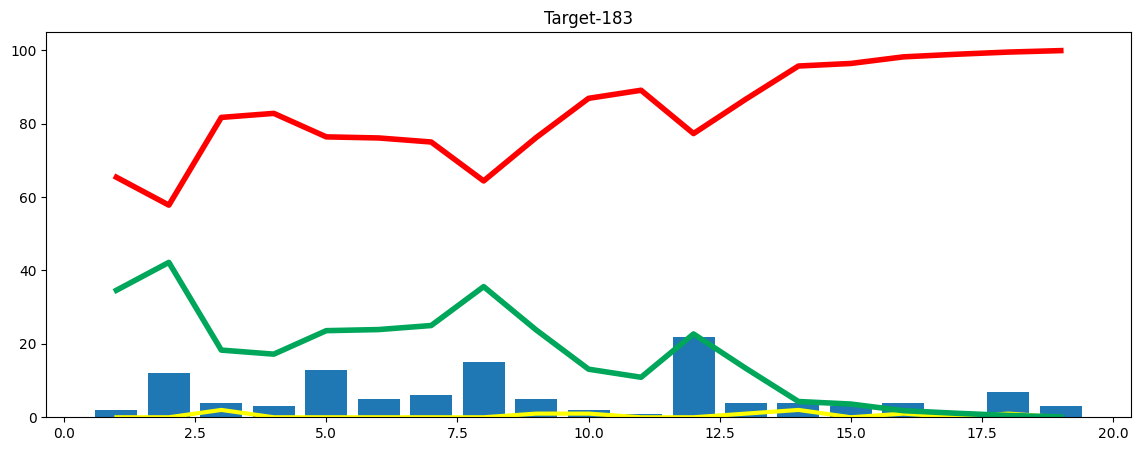

In [ ]:
plt.figure(figsize=(14,5))
plt.plot(temp_df['end_of_over'],temp_df['wickets_in_over'],color='yellow',linewidth=3)
plt.plot(temp_df['end_of_over'],temp_df['win'],color='#00a65a',linewidth=4)
plt.plot(temp_df['end_of_over'],temp_df['lose'],color='red',linewidth=4)
plt.bar(temp_df['end_of_over'],temp_df['runs_after_over'])
plt.title('Target-' + str(target))

exporting model

In [ ]:
pickle.dump(pipe,open('pipe.pkl','wb'))

In [86]:
teams

['Sunrisers Hyderabad',
 'Mumbai Indians',
 'Royal Challengers Bangalore',
 'Kolkata Knight Riders',
 'Kings XI Punjab',
 'Chennai Super Kings',
 'Rajasthan Royals',
 'Delhi Capitals']

In [89]:
final_df['city'].unique()

array(['Hyderabad', 'Mumbai', 'Bengaluru', 'Chennai', 'Kolkata', 'Jaipur',
       'Delhi', 'Dharamsala', 'Port Elizabeth', 'Ahmedabad', 'Pune',
       'Raipur', 'Cape Town', 'Bangalore', 'Durban', 'Johannesburg',
       'Bloemfontein', 'Chandigarh', 'Nagpur', 'Mohali', 'Visakhapatnam',
       'Ranchi', 'Abu Dhabi', 'Centurion', 'Indore', 'Cuttack',
       'East London', 'Kimberley', 'Sharjah'], dtype=object)

In [90]:
final_df.head()

,batting_team,bowling_team,city,runs_left,balls_left,wickets_left,total_runs_x,crr,rrr,result
119224,Delhi Capitals,Sunrisers Hyderabad,Hyderabad,120,99,9,147,7.714286,7.272727,0
53553,Kings XI Punjab,Mumbai Indians,Mumbai,54,28,6,160,6.913043,11.571429,0
148105,Royal Challengers Bangalore,Sunrisers Hyderabad,Bengaluru,54,34,7,180,8.790698,9.529412,1
9777,Chennai Super Kings,Kolkata Knight Riders,Chennai,147,116,10,148,1.500000,7.603448,1
97613,Kolkata Knight Riders,Chennai Super Kings,Kolkata,76,64,9,155,8.464286,7.125000,1
